In [5]:
# %%
"""
Dedalus script simulating 2D horizontally-periodic Rayleigh-Benard convection.
This script demonstrates solving a 2D Cartesian initial value problem. It can
be ran serially or in parallel, and uses the built-in analysis framework to save
data snapshots to HDF5 files. The `plot_snapshots.py` script can be used to
produce plots from the saved data. It should take about 5 cpu-minutes to run.

For incompressible hydro with two boundaries, we need two tau terms for each the
velocity and buoyancy. Here we choose to use a first-order formulation, putting
one tau term each on auxiliary first-order gradient variables and the others in
the PDE, and lifting them all to the first derivative basis. This formulation puts
a tau term in the divergence constraint, as required for this geometry.

To run and plot using e.g. 4 processes:
    $ mpiexec -n 4 python3 rayleigh_benard.py
    $ mpiexec -n 4 python3 plot_snapshots.py snapshots/*.h5
"""


# %%
import numpy as np
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import copy
import h5py
import numpy as np
import matplotlib
import re

import matplotlib.pyplot as plt
from dedalus.extras import plot_tools

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize

import os
from os import listdir

save_dir= "/scratch/zb2113/DedalusData/8e50.33Q=0.0014"


#if not os.path.exists(save_dir):
#    os.mkdir(save_dir)

# %%
# Parameters
Lx, Lz = 20,1
Nx, Nz = 640, 32
Ra_M = 8e5
D_0 = 0
D_H = 1/3
M_0 = 0
M_H = -1
N_s2=4/3
Qrad=0.0014

Prandtl = 1
dealias = 3/2
stop_sim_time = 600
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

# %%
# Bases
coords = d3.CartesianCoordinates('x','z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
D = dist.Field(name='D', bases=(xbasis,zbasis))
M = dist.Field(name='M', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
Z = dist.Field(name='Z', bases=zbasis)
T = dist.Field(name='T', bases=(xbasis,zbasis))
C = dist.Field(name='C', bases=(xbasis,zbasis))

tau_p = dist.Field(name='tau_p')
tau_B1 = dist.Field(name='tau_B1', bases=xbasis)
tau_B2 = dist.Field(name='tau_B2', bases=xbasis)
tau_D1 = dist.Field(name='tau_D1', bases=xbasis)
tau_D2 = dist.Field(name='tau_D2', bases=xbasis)
tau_M1 = dist.Field(name='tau_M1', bases=xbasis)
tau_M2 = dist.Field(name='tau_M2', bases=xbasis)
tau_u1 = dist.VectorField(coords,name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords,name='tau_u2', bases=xbasis)
tau_u3 = dist.Field(name='tau_u3', bases=xbasis)
tau_u4 = dist.Field(name='tau_u4', bases=xbasis)
tau_T1 = dist.Field(name='tau_t1', bases=xbasis)
tau_T2 = dist.Field(name='tau_t2', bases=xbasis)
tau_C1 = dist.Field(name='tau_c1', bases=xbasis)
tau_C2 = dist.Field(name='tau_c2', bases=xbasis)

# Substitutions    
#Kuo_Bretherton Equilibrium
kappa = (Ra_M * Prandtl/((M_0-M_H)*Lz**3))**(-1/2)
nu = (Ra_M / (Prandtl*(M_0-M_H)*Lz**3))**(-1/2)
print('kappa',kappa)
print('nu',nu)



x,z = dist.local_grids(xbasis,zbasis)
Z['g']=z
Z.change_scales(3/2)

ex,ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

B_op = (np.absolute(D - M - N_s2*Z)+ M + D - N_s2*Z)/2
lq = B_op/2 + np.absolute(B_op)



Max = lambda A,B: (abs(A-N_s2*Z-B)+A-N_s2*Z+B)/2
eva = lambda A: A.evaluate()

dz= lambda A: d3.Differentiate(A, coords['z'])
dx= lambda A: d3.Differentiate(A, coords['x'])


ux=u@ex
uz=u@ez
dxux=dx(ux)
dzux=dz(ux)
dxuz=dx(uz)
dzuz=dz(uz)

grad_u = d3.grad(u) + ez* lift(tau_u1) # First-order reduction
grad_ux = grad_u@ex # First-order reduction
grad_uz = grad_u@ez # First-order reduction
grad_M = d3.grad(M) + ez*lift(tau_M1) # First-order reduction
grad_D = d3.grad(D) + ez*lift(tau_D1) # First-order reduction
grad_T = d3.grad(T) + ez*lift(tau_T1)
grad_C = d3.grad(C) + ez*lift(tau_C1)

kappa 0.001118033988749895
nu 0.001118033988749895


In [6]:
post_dir= "/home/zb2113/Dedalus-Postanalysis/2D"
plot_dir = post_dir+ "/8e50.33Q=0.0014"
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

[0.0, 1.7175569085634136e-09, 3.3177871429445393e-09, 6.434097452286583e-09, 1.056534332955198e-08, 1.4544553478397438e-08, 1.968736048166522e-08, 2.6446481935833498e-08, 4.104026494940641e-08, 5.592821870614084e-08]
0.2622687744838614
2400
2400


/state/partition1/job-44077074/ipykernel_2180476/3719974012.py:23: RuntimeWarning: divide by zero encountered in log
  plt.plot(figure_x_axis, np.log(all_tot_ke), color = 'blue')


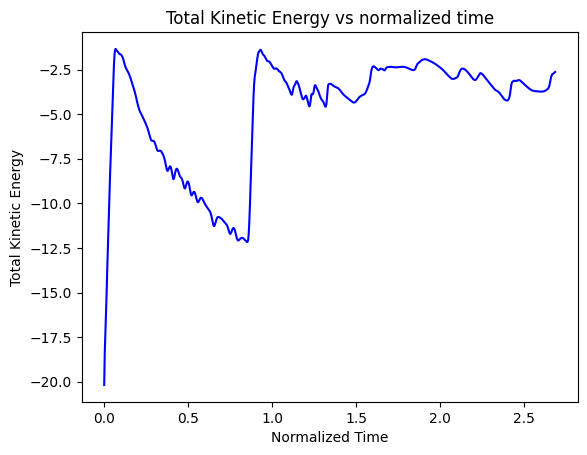

/state/partition1/job-44077074/ipykernel_2180476/3719974012.py:31: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.array(range(len(figure_x_axis))), np.log(all_tot_ke), color = 'blue')


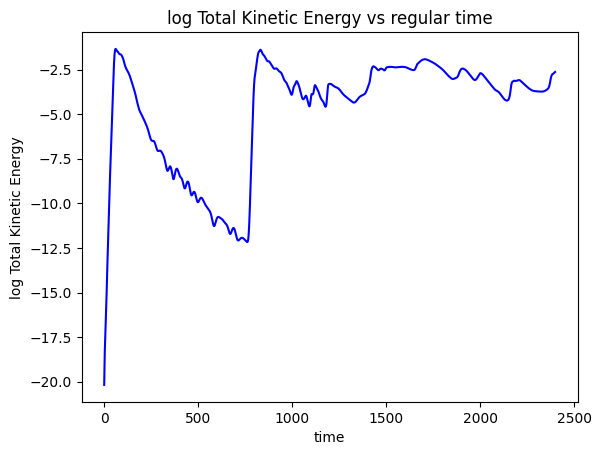

<Figure size 640x480 with 0 Axes>

In [7]:
folder_dir = save_dir+"/snapshots"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
#sort by the number in the file name
file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))

#plot the function of total KE
all_tot_ke = []

for file in file_paths:
    with h5py.File(file, mode='r') as file:
        tot_ke = file['tasks']['total KE']
        st = file['scales/sim_time']
        simtime = np.array(st)
        for t in range(0, len(simtime)):
            all_tot_ke.append(np.sum(tot_ke[t]))
print(all_tot_ke[:10])
print(max(all_tot_ke))

print(len(all_tot_ke))
figure_x_axis = np.array([(x*nu/(1**2)) for x in range(1, len(all_tot_ke)+1)])
print(len(figure_x_axis))
plt.plot(figure_x_axis, np.log(all_tot_ke), color = 'blue')
plt.xlabel('Normalized Time')
plt.ylabel('Total Kinetic Energy')
plt.title('Total Kinetic Energy vs normalized time')
plt.savefig(plot_dir+'/Total norm KE.png', dpi=200, bbox_inches='tight')
plt.show()
plt.clf()

plt.plot(np.array(range(len(figure_x_axis))), np.log(all_tot_ke), color = 'blue')
plt.xlabel('time')
plt.ylabel('log Total Kinetic Energy')
plt.title('log Total Kinetic Energy vs regular time')
plt.savefig(plot_dir+'/Total KE.png', dpi=200, bbox_inches='tight')
plt.show()
plt.clf()

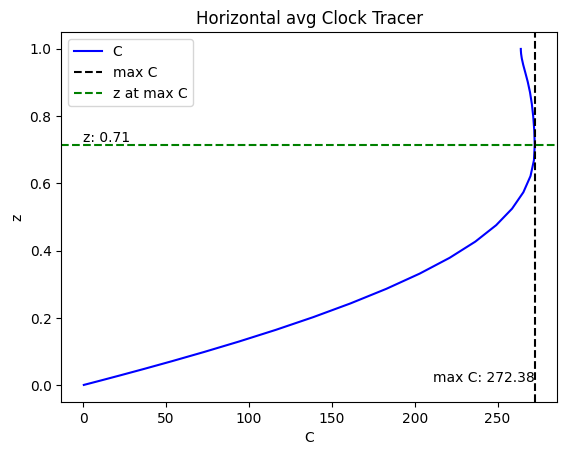

<Figure size 640x480 with 0 Axes>

In [8]:
#Plot horizontal avg C
folder_dir = save_dir + "/snapshots"

file_paths = [os.path.join(folder_dir, file) for file in os.listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
# Sort by the number in the file name
file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
# Read the last file in the file path
file = file_paths[-1]
with h5py.File(file, mode='r') as file:
    avgC = file['tasks']['horizontal avg C'][-1, 0, :]
    avgC = np.array(avgC)
    z = z.reshape(-1)
    # Plot the horizontal avg C
    plt.plot(avgC, z, color='blue', label='C')
    
    maxC = max(avgC)
    plt.axvline(x=maxC, color='black', linestyle='--', label='max C')
    
    # Find the z value corresponding to max C and add a horizontal line
    maxC_index = np.argmax(avgC)
    z_maxC = z[maxC_index]
    plt.axhline(y=z_maxC, color='green', linestyle='--', label='z at max C')
    
    # Annotate the max C and its corresponding z value
    plt.text(maxC, 0, f'max C: {maxC:.2f}', horizontalalignment='right', verticalalignment='bottom')
    plt.text(0, z_maxC, f'z: {z_maxC:.2f}', horizontalalignment='left', verticalalignment='bottom')
    
    plt.xlabel('C')
    plt.ylabel('z')
    plt.title('Horizontal avg Clock Tracer')
    plt.legend()
    plt.show()
    plt.savefig(plot_dir + '/Horizontal avg C.png', dpi=200, bbox_inches='tight')
    plt.clf()

In [7]:
folder_dir = save_dir+"/snapshots"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
#sort by the number in the file name
file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
file = file_paths[-1]
with h5py.File(file, mode='r') as file:
    print(list(file.keys()))
    scalekeys=list(file['scales'].keys())
    taskkeys=list(file['tasks'].keys())
    print(scalekeys)
    print(taskkeys)
    #automatic read x y zhash: testing feature
    xhash=scalekeys[-2]
    zhash=scalekeys[-1]
    x=file['scales'][xhash]
    z=file['scales'][zhash]
    x=np.array(x)
    z=np.array(z)

['scales', 'tasks']
['constant', 'iteration', 'sim_time', 'timestep', 'wall_time', 'world_time', 'write_number', 'x_hash_bd3a60774cff7944417ab6f620b915267af93d36', 'z_hash_379a9dade55ae037045163625e8eb5bc152eeb8d']
['C', 'D', 'Dry derivative', 'M', 'Moist derivative', 'Nusselt Number', 'T', 'horizontal avg B', 'horizontal avg C', 'horizontal avg D', 'horizontal avg M', 'horizontal avg T', 'horizontal avg liquid', 'p', 'tau_D1', 'tau_D2', 'tau_M1', 'tau_M2', 'tau_c1', 'tau_c2', 'tau_p', 'tau_t1', 'tau_t2', 'tau_u1', 'tau_u2', 'total KE', 'u', 'uz']


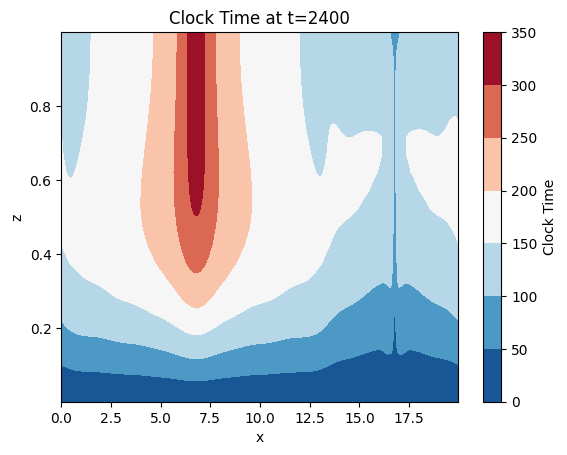

<Figure size 640x480 with 0 Axes>

In [8]:
#Plot C
folder_dir = save_dir+"/snapshots"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
#sort by the number in the file name
file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
#read the last file in the file path
file = file_paths[-1]
with h5py.File(file, mode='r') as file:
    C = np.transpose(file['tasks']['C'][-1,:,:])
    plt.contourf(x, z , C, cmap='RdBu_r')
    plt.colorbar(label='Clock Time')
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Clock Time at t=2400')
    plt.show()
    plt.savefig(plot_dir+'/C.png', dpi=200, bbox_inches='tight')
    plt.clf()
